1.Preprocessing

Image shape: (512, 512)


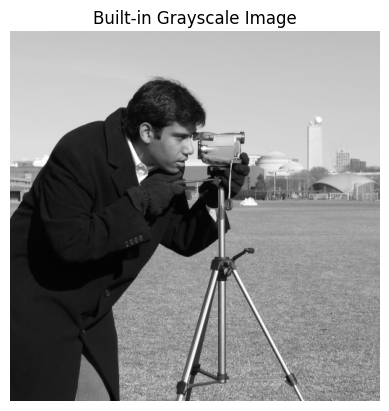

In [8]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

img = data.camera()

h, w = img.shape
img = img[:h - h % 8, :w - w % 8]
print("Image shape:", img.shape)
plt.imshow(img, cmap='gray')
plt.title("Built-in Grayscale Image")
plt.axis('off')
plt.show()

2.Block-wise SVD Function

non-overlapping 8×8 blocks

In [9]:
h, w = img.shape

print("Image shape:", img.shape)
print("Extracting first few 8x8 blocks...")

for i in range(0, min(h, 16), 8):
    for j in range(0, min(w, 16), 8):
        block = img[i:i+8, j:j+8]
        print(f"\nBlock at ({i}, {j}):\n", block)

Image shape: (512, 512)
Extracting first few 8x8 blocks...

Block at (0, 0):
 [[200 200 200 200 199 200 199 198]
 [200 199 199 200 199 200 199 198]
 [199 199 199 200 200 200 200 200]
 [200 200 199 199 199 199 199 199]
 [200 200 200 200 199 199 199 200]
 [200 199 199 200 199 199 199 199]
 [200 201 200 200 199 200 198 199]
 [201 200 200 200 200 199 199 200]]

Block at (0, 8):
 [[199 198 198 198 198 198 198 198]
 [198 199 199 199 199 199 198 198]
 [200 200 200 199 200 199 198 198]
 [198 199 198 198 199 198 198 199]
 [199 199 198 198 199 199 200 199]
 [199 199 198 198 199 199 199 198]
 [199 199 199 199 200 200 199 198]
 [200 199 200 199 199 200 199 199]]

Block at (8, 0):
 [[200 200 200 199 200 200 200 199]
 [200 200 199 200 200 200 201 200]
 [200 200 201 200 200 201 200 200]
 [201 199 200 200 199 200 200 200]
 [200 199 198 200 200 200 200 202]
 [200 199 199 199 200 201 201 201]
 [201 199 200 200 199 201 201 200]
 [201 201 201 199 201 200 200 201]]

Block at (8, 8):
 [[199 199 199 198 199 

Implement compress_block(block, k)

In [10]:
def compress_block(block, k):
    U, S, Vt = np.linalg.svd(block, full_matrices=False)
    S[k:] = 0
    compressed = np.dot(U, np.dot(np.diag(S), Vt))
    return compressed

In [11]:
sample_block = img[0:8, 0:8]
compressed_block = compress_block(sample_block, k=4)
print("Original Block:\n", sample_block)
print("\nCompressed Block (k=4):\n", compressed_block.astype(np.uint8))

Original Block:
 [[200 200 200 200 199 200 199 198]
 [200 199 199 200 199 200 199 198]
 [199 199 199 200 200 200 200 200]
 [200 200 199 199 199 199 199 199]
 [200 200 200 200 199 199 199 200]
 [200 199 199 200 199 199 199 199]
 [200 201 200 200 199 200 198 199]
 [201 200 200 200 200 199 199 200]]

Compressed Block (k=4):
 [[200 200 199 200 198 200 198 198]
 [199 199 199 199 199 199 199 197]
 [199 199 198 200 199 199 200 200]
 [199 199 199 199 198 198 198 199]
 [200 200 199 199 199 199 198 199]
 [200 199 199 199 199 199 199 198]
 [199 201 200 199 198 199 198 198]
 [201 200 199 200 199 198 199 200]]


Recombine blocks into a full image

In [12]:
def compress_image_blockwise(img, k):
    h, w = img.shape
    compressed_img = np.zeros_like(img, dtype=np.float32)

    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img[i:i+8, j:j+8]
            compressed_block = compress_block(block, k)
            compressed_img[i:i+8, j:j+8] = compressed_block

    return np.clip(compressed_img, 0, 255).astype(np.uint8)

Final Image

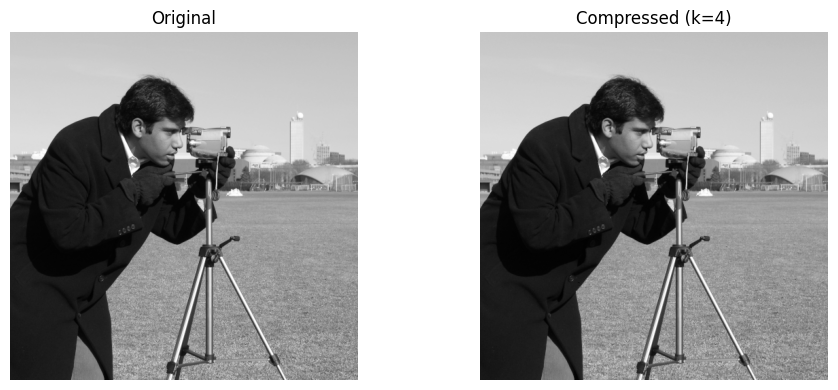

In [13]:
compressed_img = compress_image_blockwise(img, k=4)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compressed_img, cmap='gray')
plt.title("Compressed (k=4)")
plt.axis('off')

plt.tight_layout()
plt.show()

3.Compression Analysis

Apply Block-wise SVD for each k ∈ {1,...,8}

In [14]:
compressed_images = {}
k_values = list(range(1, 9))

for k in k_values:
    compressed_images[k] = compress_image_blockwise(img, k)

Compute Compression Ratio for each k

In [15]:
compression_ratios = []

for k in k_values:
    original_values = 64
    retained_values = k * (8 + 8 + 1)
    ratio = original_values / retained_values
    compression_ratios.append(ratio)

print("Compression Ratios for k = 1 to 8:\n", compression_ratios)

Compression Ratios for k = 1 to 8:
 [3.764705882352941, 1.8823529411764706, 1.2549019607843137, 0.9411764705882353, 0.7529411764705882, 0.6274509803921569, 0.5378151260504201, 0.47058823529411764]


In [16]:
import os

output_folder = "compressed_outputs"
os.makedirs(output_folder, exist_ok=True)

for k, image in compressed_images.items():
    filename = f"{output_folder}/compressed_k{k}.png"
    cv2.imwrite(filename, image)

print(f"Compressed images saved in '{output_folder}' folder.")

Compressed images saved in 'compressed_outputs' folder.


4.Visualization

Compression Ratio vs. k

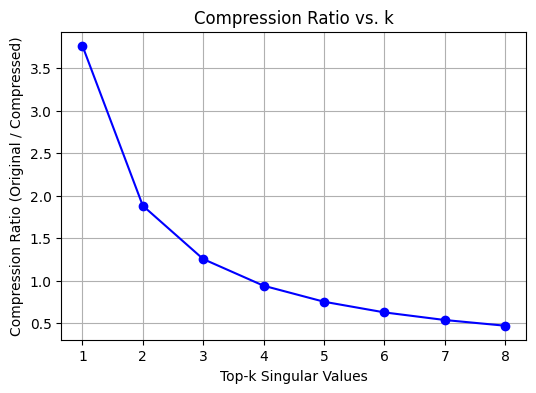

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(k_values, compression_ratios, marker='o', linestyle='-', color='blue')
plt.title("Compression Ratio vs. k")
plt.xlabel("Top-k Singular Values")
plt.ylabel("Compression Ratio (Original / Compressed)")
plt.grid(True)
plt.xticks(k_values)
plt.show()

Reconstruction Error (Frobenius norm) vs. k

In [21]:
import numpy as np

def frobenius_norm(original, compressed):
    return np.linalg.norm(original.astype(np.float32) - compressed.astype(np.float32))

frobenius_errors = []
k_values = list(range(1, 9))

for k in k_values:
    compressed = compressed_images[k]
    error = frobenius_norm(img, compressed)
    frobenius_errors.append(error)

print("Frobenius Errors for each k:\n", frobenius_errors)

Frobenius Errors for each k:
 [np.float32(5150.507), np.float32(2980.8381), np.float32(1901.6119), np.float32(1261.5371), np.float32(808.7836), np.float32(506.0178), np.float32(357.2366), np.float32(0.0)]


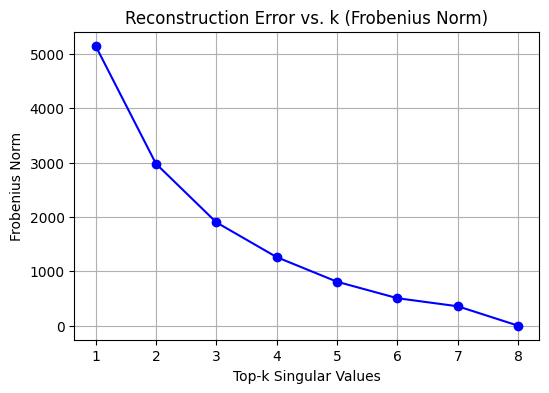

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(k_values, frobenius_errors, marker='o', linestyle='-', color='blue')
plt.title("Reconstruction Error vs. k (Frobenius Norm)")
plt.xlabel("Top-k Singular Values")
plt.ylabel("Frobenius Norm")
plt.grid(True)
plt.xticks(k_values)
plt.show()

PSNR (Peak Signal-to-Noise Ratio).

In [25]:
def psnr(original, compressed):
    mse = np.mean((original.astype(np.float32) - compressed.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(255**2 / mse)

psnr_values = []
k_values = list(range(1, 9))

for k in k_values:
    compressed = compressed_images[k]
    psnr_val = psnr(img, compressed)
    psnr_values.append(psnr_val)

print("PSNR values (in dB) for each k:\n", psnr_values)

PSNR values (in dB) for each k:
 [np.float32(28.079205), np.float32(32.829433), np.float32(36.733765), np.float32(40.298203), np.float32(44.159554), np.float32(48.232887), np.float32(51.257088), inf]


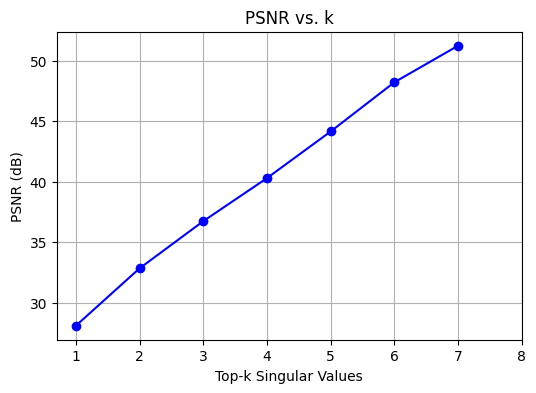

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(k_values, psnr_values, marker='o', linestyle='-', color='blue')
plt.title("PSNR vs. k")
plt.xlabel("Top-k Singular Values")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.xticks(k_values)
plt.show()